# Simulating synaptic activation

[The previous notebook](./2.1%20Anatomical%20embedding.ipynb) provided us with an anatomical reconstruction of the barrel cortex, defining locations of presynaptic cells, and post-synaptic targets onto our cell of interest: an L5PT.

Now we need to activate the synapses according to experimental data, such that the synapse activation represents a passive touch experiment.

To do this, we need the following information
 1. A parameter file specifying characteristics of the synaspses by celltype
 2. A parameterfile specifying the ongoing activity by celltype
 3. Parameterfiles specifying evoked response by stimulus, celltype and celllocation

In [1]:
import Interface as I
from getting_started import getting_started_dir
db = I.DataBase('{}/labs/getting_started_db/'.format(I.os.environ['HOME']))

con_file = db['anatomical_constraints'].get_file('.con')
con_file_path = db['anatomical_constraints'].join(con_file)
syn_file = db['anatomical_constraints'].get_file('.syn')
syn_file_path = db['anatomical_constraints'].join(syn_file)

[INFO] l5pt: Loading mechanisms:


--No graphics will be displayed.


[INFO] distributed_lock: trying to connect to distributed locking server {'config': {'hosts': 'somalogin02:33333'}, 'type': 'zookeeper'}
[INFO] distributed_lock: success!
[INFO] ISF: Current version: heads/docs+0.gc6b09d63.dirty
[INFO] ISF: Current pid: 170732
[WARNING] warnings: /gpfs/soma_fs/scratch/meulemeester/envs/anaconda_isf3.8/lib/python3.8/site-packages/pandas_msgpack-0.1.4+14.gfcb0471.dirty-py3.8-linux-x86_64.egg/pandas_msgpack/packers.py:78: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import (Timestamp, Period, Series, DataFrame,  # noqa

[WARNING] cell_morphology_visualizer: cannot import name 'escape' from 'jinja2' (/gpfs/soma_fs/scratch/meulemeester/envs/anaconda_isf3.8/lib/python3.8/site-packages/jinja2/__init__.py)
[WARNING] warnings: /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/Interface.py:212: UserWarning: The source folder has uncommited 

## Step 1: characterize ongoing activity

In [2]:
getting_started_dir

'/gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/getting_started'

In [3]:
ongoing_template_param_name = I.os.path.join(
    getting_started_dir, 
    'example_data',
    'functional_constraints',
    'ongoing_activity',
    'ongoing_activity_celltype_template_exc_conductances_fitted.param')

In this parameter file, the following keys are defined

In [4]:
ongoing_template_param = I.scp.build_parameters(ongoing_template_param_name)
ongoing_template_param.keys()

dict_keys(['info', 'network', 'NMODL_mechanisms'])

The most relevant information is specified in the network key:

In [5]:
ongoing_template_param.network.keys()

dict_keys(['L2', 'L34', 'L4py', 'L4sp', 'L4ss', 'L5st', 'L5tt', 'L6cc', 'L6ccinv', 'L6ct', 'VPM', 'L1', 'L23Trans', 'L45Peak', 'L45Sym', 'L56Trans', 'SymLocal1', 'SymLocal2', 'SymLocal3', 'SymLocal4', 'SymLocal5', 'SymLocal6'])

Here, parameters are defined for each presynaptic celltype:

In [6]:
ongoing_template_param.network.L5tt

{'celltype': 'spiketrain',
 'interval': 283.3,
 'synapses': {'receptors': {'glutamate_syn': {'threshold': 0.0,
    'delay': 0.0,
    'parameter': {'tau1': 26.0,
     'tau2': 2.0,
     'tau3': 2.0,
     'tau4': 0.1,
     'decayampa': 1.0,
     'decaynmda': 1.0,
     'facilampa': 0.0,
     'facilnmda': 0.0},
    'weight': [1.59, 1.59]}},
  'releaseProb': 0.6}}

 - `interval`: mean ongoing interspike interval
 - `releaseProb`: chance that synapse gets activated if presynaptic cell gets activated
 - `synapses.receptors.glutamate_syn.parameter`: 
    - parameters for the NEURON mechanism defined in [mechanisms.channels](../../../mechanisms/l5pt/__init__.py)
      - `tau1`: NMDA decay time
      - `tau2`: NMDA rise time
      - `tau3`: AMPA decay time
      - `tau4`: AMPA rise time
 - `synapses.receptors.weight`
      - maximum conductance of the synapse for AMPA and NMDA, respectively

## Step 2: characterize evoked activity

Evoked activity captures the network activity during a specific *in-vivo* condition.
The experimental condition we will consider here is a passive whisker touch of the rat.
We have files capturing the activity of all celltypes in all locations across the rat barrel cortex.
Let's see what their activity was when we touched the whisker in arc C, row 2.

In [7]:
evokedPrefix = I.os.path.join(getting_started_dir, 'example_data/functional_constraints/evoked_activity/PW_SuW_RF_CDK/')
excitatory_PSTHs = [fname for fname in I.os.listdir(evokedPrefix) if fname.endswith('PSTH_UpState.param')]
inhibitory_PSTHs = [fname for fname in I.os.listdir(evokedPrefix) if fname.endswith('active_timing_normalized_PW_1.0_SuW_0.5.param')]

Let's have a look at a specific parameterfile:

In [8]:
excitatory_PSTHs

['L4ss_3x3_PSTH_UpState.param',
 'L4sp_3x3_PSTH_UpState.param',
 'L4py_3x3_PSTH_UpState.param',
 'L5st_3x3_PSTH_UpState.param',
 'L6ct_3x3_PSTH_UpState.param',
 'L6cc_3x3_PSTH_UpState.param',
 'L6ccinv_3x3_PSTH_UpState.param',
 'L2_3x3_PSTH_UpState.param',
 'L34_3x3_PSTH_UpState.param',
 'L5tt_3x3_PSTH_UpState.param']

In [9]:
example_PSTH = I.scp.build_parameters(I.os.path.join(evokedPrefix, excitatory_PSTHs[-5]))
example_PSTH.keys()

dict_keys(['L6cc_B1', 'L6cc_B2', 'L6cc_B3', 'L6cc_C1', 'L6cc_C2', 'L6cc_C3', 'L6cc_D1', 'L6cc_D2', 'L6cc_D3'])

We have entries for each column, each containing the respective evoked PSTH in a C2 stimulus scenario:

In [10]:
example_PSTH['L6cc_B1'].keys()

dict_keys(['distribution', 'intervals', 'probabilities'])

In [11]:
for k,v in example_PSTH['L6cc_B1'].items():
    print('{}: {}\n'.format(k,v))

distribution: PSTH

intervals: [(10.0, 11.0), (11.0, 12.0), (20.0, 21.0), (22.0, 23.0), (32.0, 33.0), (33.0, 34.0), (34.0, 35.0), (36.0, 37.0), (37.0, 38.0), (41.0, 42.0), (43.0, 44.0), (45.0, 46.0)]

probabilities: [0.0034, 0.0034, 0.0072, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034, 0.0034]



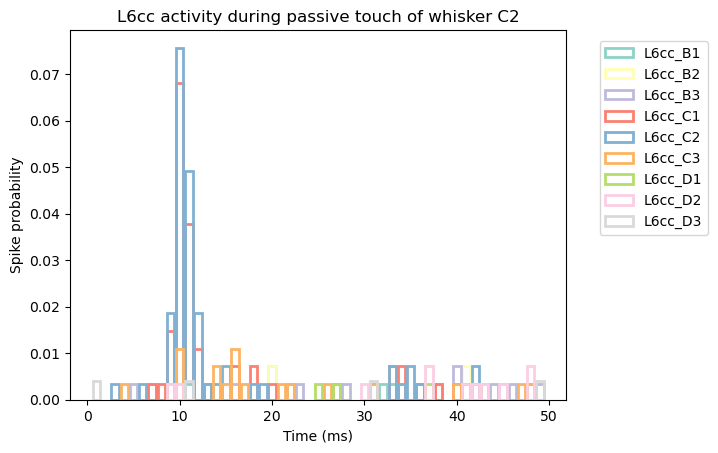

In [12]:
%matplotlib inline
cmap = I.plt.get_cmap('Set3')
fig, ax = I.plt.subplots()
for i, celltype in enumerate(example_PSTH.keys()):
    x = [b[0] for b in example_PSTH[celltype]['intervals']]
    I.plt.bar(
        x, 
        example_PSTH[celltype]['probabilities'], 
        facecolor="#00000000", 
        edgecolor=cmap(i),
        lw=2,
        label=celltype)
I.plt.legend(bbox_to_anchor=(1.3, .99))
I.plt.xlabel("Time (ms)")
I.plt.ylabel("Spike probability")
I.plt.title("L6cc activity during passive touch of whisker C2")
I.plt.show()

## Step 3: Combine ongoing and evoked activity into a network parameter file

Next, we combine all data to one parameterfile, which then describes the activation of presynaptic cells and synapses during a **passive whisker touch** scenario, given our cellmorphology and the anatomical network realization. To so, we use the `create_evoked_network_parameter` function:

In [13]:
whisker = 'C2' 
# cell number spreadsheet generated in anatomical realization step.
cell_number_file_name = db['anatomical_constraints'].join('NumberOfConnectedCells.csv')
if not 'network_param' in db.keys(): db.create_managed_folder('network_param')
out_file_name = db['network_param'].join('C2_stim.param')
I.create_evoked_network_parameter(
    ongoing_template_param_name, 
    cell_number_file_name,
    syn_file_path, 
    con_file_path, 
    whisker, 
    out_file_name
)

*************
creating network parameter file from template /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/getting_started/example_data/functional_constraints/ongoing_activity/ongoing_activity_celltype_template_exc_conductances_fitted.param
*************


Let's also generate parameterfiles for surround whisker stimuli!

In [14]:
with I.silence_stdout:
    for whisker in ['B1', 'B2', 'B3', 'C1', 'C3', 'D1', 'D2', 'D3']:
        I.create_evoked_network_parameter(
            ongoing_template_param_name, 
            cell_number_file_name, 
            syn_file_path, con_file_path, 
            whisker,
            db['network_param'].join('{}_stim.param'.format(whisker))
            )

##### what does the result look like?

In [15]:
network_param_C2 = I.scp.build_parameters(db['network_param'].join('C2_stim.param'))

In [16]:
network_param_C2.keys()

dict_keys(['info', 'NMODL_mechanisms', 'network'])

In [17]:
network_param_C2.network.keys()

dict_keys(['L2_Alpha', 'L2_B1', 'L2_B2', 'L2_B3', 'L2_B4', 'L2_Beta', 'L2_C1', 'L2_C2', 'L2_C3', 'L2_C4', 'L2_D1', 'L2_D2', 'L2_D3', 'L2_D4', 'L2_E1', 'L2_E2', 'L2_Gamma', 'L34_A1', 'L34_A2', 'L34_A3', 'L34_A4', 'L34_Alpha', 'L34_B1', 'L34_B2', 'L34_B3', 'L34_B4', 'L34_Beta', 'L34_C1', 'L34_C2', 'L34_C3', 'L34_C4', 'L34_D1', 'L34_D2', 'L34_D3', 'L34_Delta', 'L34_E1', 'L34_E2', 'L34_E3', 'L34_Gamma', 'L4py_A1', 'L4py_A2', 'L4py_A3', 'L4py_A4', 'L4py_Alpha', 'L4py_B1', 'L4py_B2', 'L4py_B3', 'L4py_B4', 'L4py_C1', 'L4py_C2', 'L4py_C3', 'L4py_C4', 'L4py_D1', 'L4py_D2', 'L4py_D3', 'L4py_Gamma', 'L4sp_B1', 'L4sp_B2', 'L4sp_B3', 'L4sp_Beta', 'L4sp_C1', 'L4sp_C2', 'L4sp_C3', 'L4sp_C4', 'L4sp_D1', 'L4sp_D2', 'L4sp_D3', 'L4sp_Delta', 'L4ss_A1', 'L4ss_B1', 'L4ss_B2', 'L4ss_B3', 'L4ss_C1', 'L4ss_C2', 'L4ss_C3', 'L4ss_D1', 'L4ss_D2', 'L4ss_D3', 'L4ss_E1', 'L5st_A1', 'L5st_A2', 'L5st_A3', 'L5st_Alpha', 'L5st_B1', 'L5st_B2', 'L5st_B3', 'L5st_B4', 'L5st_Beta', 'L5st_C1', 'L5st_C2', 'L5st_C3', 'L5st_C4'

Lets have a look at what the parameterfile specifies about L5tt cells in C2

In [18]:
for k, v in dict(network_param_C2.network.L5tt_C2).items():
    print('{}: {}\n'.format(k,v))

celltype: {'spiketrain': {'interval': 283.3}, 'pointcell': {'distribution': 'PSTH', 'intervals': [(5.0, 6.0), (9.0, 10.0), (11.0, 12.0), (12.0, 13.0), (13.0, 14.0), (14.0, 15.0), (15.0, 16.0), (16.0, 17.0), (18.0, 19.0), (19.0, 20.0), (20.0, 21.0), (21.0, 22.0), (22.0, 23.0), (23.0, 24.0), (24.0, 25.0), (25.0, 26.0), (26.0, 27.0), (27.0, 28.0), (28.0, 29.0), (29.0, 30.0), (31.0, 32.0), (32.0, 33.0), (33.0, 34.0), (34.0, 35.0), (35.0, 36.0), (37.0, 38.0), (38.0, 39.0), (40.0, 41.0), (41.0, 42.0), (43.0, 44.0), (44.0, 45.0), (45.0, 46.0), (46.0, 47.0), (47.0, 48.0), (48.0, 49.0), (49.0, 50.0)], 'probabilities': [0.0009, 0.0009, 0.0035, 0.0111, 0.034, 0.0263, 0.0162, 0.006, 0.0035, 0.0111, 0.0035, 0.0009, 0.0009, 0.0009, 0.0086, 0.0035, 0.0009, 0.006, 0.0035, 0.0035, 0.0009, 0.0086, 0.0009, 0.0009, 0.0009, 0.0009, 0.006, 0.006, 0.0035, 0.0035, 0.0009, 0.006, 0.0035, 0.0009, 0.0035, 0.0009], 'offset': 245.0}}

synapses: {'receptors': {'glutamate_syn': {'threshold': 0.0, 'delay': 0.0, 'para

In [19]:
cell_types = network_param_C2.network.keys()
cell_types

dict_keys(['L2_Alpha', 'L2_B1', 'L2_B2', 'L2_B3', 'L2_B4', 'L2_Beta', 'L2_C1', 'L2_C2', 'L2_C3', 'L2_C4', 'L2_D1', 'L2_D2', 'L2_D3', 'L2_D4', 'L2_E1', 'L2_E2', 'L2_Gamma', 'L34_A1', 'L34_A2', 'L34_A3', 'L34_A4', 'L34_Alpha', 'L34_B1', 'L34_B2', 'L34_B3', 'L34_B4', 'L34_Beta', 'L34_C1', 'L34_C2', 'L34_C3', 'L34_C4', 'L34_D1', 'L34_D2', 'L34_D3', 'L34_Delta', 'L34_E1', 'L34_E2', 'L34_E3', 'L34_Gamma', 'L4py_A1', 'L4py_A2', 'L4py_A3', 'L4py_A4', 'L4py_Alpha', 'L4py_B1', 'L4py_B2', 'L4py_B3', 'L4py_B4', 'L4py_C1', 'L4py_C2', 'L4py_C3', 'L4py_C4', 'L4py_D1', 'L4py_D2', 'L4py_D3', 'L4py_Gamma', 'L4sp_B1', 'L4sp_B2', 'L4sp_B3', 'L4sp_Beta', 'L4sp_C1', 'L4sp_C2', 'L4sp_C3', 'L4sp_C4', 'L4sp_D1', 'L4sp_D2', 'L4sp_D3', 'L4sp_Delta', 'L4ss_A1', 'L4ss_B1', 'L4ss_B2', 'L4ss_B3', 'L4ss_C1', 'L4ss_C2', 'L4ss_C3', 'L4ss_D1', 'L4ss_D2', 'L4ss_D3', 'L4ss_E1', 'L5st_A1', 'L5st_A2', 'L5st_A3', 'L5st_Alpha', 'L5st_B1', 'L5st_B2', 'L5st_B3', 'L5st_B4', 'L5st_Beta', 'L5st_C1', 'L5st_C2', 'L5st_C3', 'L5st_C4'

In [20]:
surround_column_map = {
    'A1': {'Alpha': 4, 'A1': 5, 'A2': 6, 'B1': 8, 'B2': 9},\
    'A2': {'A1': 4, 'A2': 5, 'A3': 6, 'B1': 7, 'B2': 8, 'B3': 9},\
    'A3': {'A2': 4, 'A3': 5, 'A4': 6, 'B2': 7, 'B3': 8, 'B4': 9},\
    'A4': {'A3': 4, 'A4': 5, 'B3': 7, 'B4': 8},\
    'Alpha': {'Alpha': 5, 'A1': 6, 'Beta': 8, 'B1': 9},\
    'B1': {'Alpha': 1, 'A1': 2, 'A2': 3, 'Beta': 4, 'B1': 5, 'B2': 6, 'C1': 8, 'C2': 9},\
    'B2': {'A1': 1, 'A2': 2, 'A3': 3, 'B1': 4, 'B2': 5, 'B3': 6, 'C1': 7, 'C2': 8, 'C3': 9},\
    'B3': {'A2': 1, 'A3': 2, 'A4': 3, 'B2': 4, 'B3': 5, 'B4': 6, 'C2': 7, 'C3': 8, 'C4': 9},\
    'B4': {'A3': 1, 'A4': 2, 'B3': 4, 'B4': 5, 'C3': 7, 'C4': 8},\
    'Beta': {'Alpha': 2, 'Beta': 5, 'B1': 6, 'Gamma': 8, 'C1': 9},\
    'C1': {'Beta': 1, 'B1': 2, 'B2': 3, 'Gamma': 4, 'C1': 5, 'C2': 6, 'D1': 8, 'D2': 9},\
    'C2': {'B1': 1, 'B2': 2, 'B3': 3, 'C1': 4, 'C2': 5, 'C3': 6, 'D1': 7, 'D2': 8, 'D3': 9},\
    'C3': {'B2': 1, 'B3': 2, 'B4': 3, 'C2': 4, 'C3': 5, 'C4': 6, 'D2': 7, 'D3': 8, 'D4': 9},\
    'C4': {'B3': 1, 'B4': 2, 'C3': 4, 'C4': 5, 'D3': 7, 'D4': 8},\
    'Gamma': {'Beta': 2, 'Gamma': 5, 'C1': 6, 'Delta': 8, 'D1': 9},\
    'D1': {'Gamma': 1, 'C1': 2, 'C2': 3, 'Delta': 4, 'D1': 5, 'D2': 6, 'E1': 8, 'E2': 9},\
    'D2': {'C1': 1, 'C2': 2, 'C3': 3, 'D1': 4, 'D2': 5, 'D3': 6, 'E1': 7, 'E2': 8, 'E3': 9},\
    'D3': {'C2': 1, 'C3': 2, 'C4': 3, 'D2': 4, 'D3': 5, 'D4': 6, 'E2': 7, 'E3': 8, 'E4': 9},\
    'D4': {'C3': 1, 'C4': 2, 'D3': 4, 'D4': 5, 'E3': 7, 'E4': 8},\
    'Delta': {'Gamma': 2, 'Delta': 5, 'D1': 6, 'E1': 9},\
    'E1': {'Delta': 1, 'D1': 2, 'D2': 3, 'E1': 5, 'E2': 6},\
    'E2': {'D1': 1, 'D2': 2, 'D3': 3, 'E1': 4, 'E2': 5, 'E3': 6},\
    'E3': {'D2': 1, 'D3': 2, 'D4': 3, 'E2': 4, 'E3': 5, 'E4': 6},\
    'E4': {'D3': 1, 'D4': 2, 'E3': 4, 'E4': 5}}

def activity_gridplot(celltype, deflected_whisker="C2", network_param=network_param_C2):
    surround_columns = surround_column_map[deflected_whisker]
    rows = list(set([e[1] for e in surround_columns]))
    n_rows = len(rows)
    columns = list(set([e[0] for e in surround_columns]))
    columns.sort()
    n_columns = len(columns)

    fig, axs = I.plt.subplots(n_rows, n_columns, sharey=True, sharex=True)
    handles, labels = [], []
    for surround_column in surround_columns:
        row = int(surround_column[-1])
        column = surround_column[-2]
        axs[row-1][0].set_ylabel(row)
        axs[0][columns.index(column)].set_xlabel(column)
        axs[0][columns.index(column)].xaxis.set_label_position('top') 
        
        cell_type = ct+"_{}{}".format(column, row)
        if cell_type not in network_param.network.keys():
            continue
        if not 'pointcell' in network_param.network[cell_type]['celltype']:
            continue
        x = [b[0] for b in network_param.network[cell_type]['celltype']['pointcell']['intervals']]

        if row == 2 and column == "C":
            # barrel of the whisker deflection
            color = cmap(3)
        else:
            color = "Grey"
            
        bar = axs[row-1][columns.index(column)].bar(
            x, 
            network_param.network[cell_type]['celltype']['pointcell']['probabilities'], 
            facecolor=color, 
            edgecolor=color,
            lw=2,
            label=label)

        if label != "" and label not in labels:
            handles.append(bar)
            labels.append(label)
    
    axs[1, 0].set_ylabel("Row\n 2")
    I.plt.suptitle("Activity of {} during passive touch of whisker C2".format(ct))
    return fig, axs

NameError: name 'label' is not defined

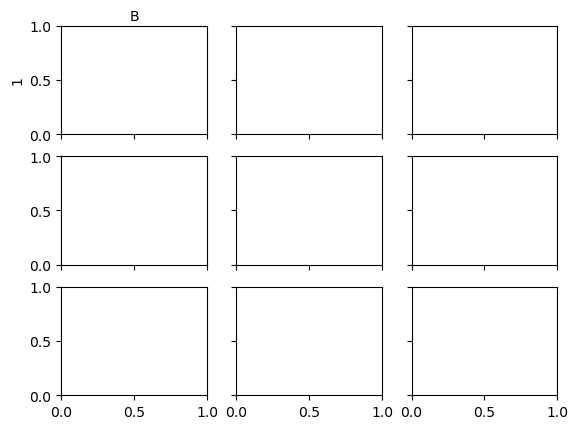

In [21]:
ct = "L6cc"
fig, axs = activity_gridplot(ct)
I.plt.show()

In [ ]:
ct = "L5tt"
fig, axs = activity_gridplot(ct)
I.plt.show()

As you see, all information is integrated

`network.[population].celltype.pointcell.offset`: timepoint at which the evoked activity starts 

## Recap

[Tutorial 2.1](./2.1%20Anatomical%20embedding.ipynb) covered how to embed a neuron model into a network reconstruction, taking into account the relevant morphological, cellular and network properties. This tutorial covered how to generate synaptic activity. We are now ready to combine our biophysically detailed neuron model with this network model: see [Tutorial 3.1](../3.%20multiscale%20models/3.1%20Multiscale%20modeling.ipynb).